# 🔬 Classificação de Câncer de Pele com CNN

Este notebook implementa uma **Rede Neural Convolucional (CNN)** para classificar lesões de pele usando o dataset **HAM10000**.

## 📊 Objetivo

Classificar imagens dermatoscópicas em **7 categorias** diferentes de lesões de pele:
1. **Melanoma (mel)** - Melanoma maligno
2. **Nevos melanocíticos (nv)** - Nevos melanocíticos benignos
3. **Carcinoma basocelular (bcc)** - Carcinoma basocelular
4. **Queratose actínica (akiec)** - Queratose actínica / Carcinoma in situ
5. **Queratose benigna (bkl)** - Queratose benigna
6. **Dermatofibroma (df)** - Dermatofibroma
7. **Lesões vasculares (vasc)** - Lesões vasculares

## 🎯 Abordagem

Vamos usar **apenas as imagens** (análise puramente visual) para a classificação, sem utilizar metadados como idade, sexo ou localização. Isso permitirá comparação justa com modelos Vision Transformer e VLMs posteriormente.

---
# 1️⃣ Setup e Importações

In [50]:
# Configurar para não exibir warnings desnecessários
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas essenciais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
from PIL import Image

# Scikit-learn para métricas e divisão de dados
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow e Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# Configurar seeds para reprodutibilidade
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print(f"TensorFlow versão: {tf.__version__}")
print(f"GPU disponível: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow versão: 2.20.0
GPU disponível: False


### 📌 Configurações Globais

In [ ]:
# Dimensões das imagens (reduzidas para treino mais rápido)
IMG_WIDTH = 100
IMG_HEIGHT = 75
IMG_CHANNELS = 3

# Hiperparâmetros
BATCH_SIZE = 10
EPOCHS = 50
LEARNING_RATE = 0.001

# Número de classes
NUM_CLASSES = 7

# Caminhos
BASE_DIR = os.path.join('..', 'data', 'raw')
MODELS_DIR = os.path.join('..', 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

print(f"Diretório base: {BASE_DIR}")
print(f"Diretório de modelos: {MODELS_DIR}")
print(f"\nConfigurações:")
print(f"  Imagens: {IMG_WIDTH}x{IMG_HEIGHT}x{IMG_CHANNELS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")

Diretório base: ..\data\raw
Diretório de modelos: ..\models

Configurações:
  Imagens: 100x75x3
  Batch size: 10
  Epochs: 50
  Learning rate: 0.01


---
# 2️⃣ Carregamento e Preparação dos Dados

Vamos carregar os metadados e criar um mapeamento para as imagens.

In [77]:
# Carregar metadados
metadata_path = os.path.join(BASE_DIR, 'HAM10000_metadata.csv')
df = pd.read_csv(metadata_path)

print(f"📊 Total de imagens: {len(df)}")
print(f"\n🔍 Primeiras linhas:")
df.head()

📊 Total de imagens: 10015

🔍 Primeiras linhas:


lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

In [78]:
# Criar mapeamento image_id -> caminho completo da imagem
# As imagens estão em duas pastas diferentes
image_paths = {}
for folder in ['HAM10000_images_part_1', 'HAM10000_images_part_2']:
    folder_path = os.path.join(BASE_DIR, folder)
    if os.path.exists(folder_path):
        for img_file in glob(os.path.join(folder_path, '*.jpg')):
            image_id = os.path.splitext(os.path.basename(img_file))[0]
            image_paths[image_id] = img_file

print(f"✅ Total de imagens encontradas: {len(image_paths)}")

# Adicionar caminho das imagens ao dataframe
df['image_path'] = df['image_id'].map(image_paths)

# Verificar se todas as imagens foram encontradas
missing = df['image_path'].isna().sum()
if missing > 0:
    print(f"⚠️ ATENÇÃO: {missing} imagens não foram encontradas!")
    df = df.dropna(subset=['image_path'])
else:
    print("✅ Todas as imagens foram encontradas!")

✅ Total de imagens encontradas: 10015
✅ Todas as imagens foram encontradas!


In [79]:
# Dicionário com nomes amigáveis das classes
class_names = {
    'nv': 'Nevos melanocíticos',
    'mel': 'Melanoma',
    'bkl': 'Queratose benigna',
    'bcc': 'Carcinoma basocelular',
    'akiec': 'Queratose actínica',
    'vasc': 'Lesões vasculares',
    'df': 'Dermatofibroma'
}
# Adicionar nome amigável e índice numérico
df['class_name'] = df['dx'].map(class_names)
df['class_idx'] = pd.Categorical(df['dx']).codes

print("\n📋 Mapeamento de classes:")
for idx, (code, name) in enumerate(class_names.items()):
    count = (df['dx'] == code).sum()
    print(f"  {idx}: {code:6s} -> {name:30s} ({count:4d} imagens)")


📋 Mapeamento de classes:
  0: nv     -> Nevos melanocíticos            (6705 imagens)
  1: mel    -> Melanoma                       (1113 imagens)
  2: bkl    -> Queratose benigna              (1099 imagens)
  3: bcc    -> Carcinoma basocelular          ( 514 imagens)
  4: akiec  -> Queratose actínica             ( 327 imagens)
  5: vasc   -> Lesões vasculares              ( 142 imagens)
  6: df     -> Dermatofibroma                 ( 115 imagens)


### 🧹 Limpeza de Dados

In [80]:
# Verificar valores faltantes
print("❓ Valores faltantes por coluna:")
print(df.isnull().sum())

# Preencher idade faltante com a média
df['age'].fillna(df['age'].mean(), inplace=True)

print(f"\n✅ Dataset limpo com {len(df)} registros")

❓ Valores faltantes por coluna:
lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
image_path       0
class_name       0
class_idx        0
dtype: int64

✅ Dataset limpo com 10015 registros


---
# 3️⃣ Análise Exploratória de Dados (EDA)

Vamos entender a distribuição dos dados antes de treinar o modelo.

### 📊 Distribuição das Classes

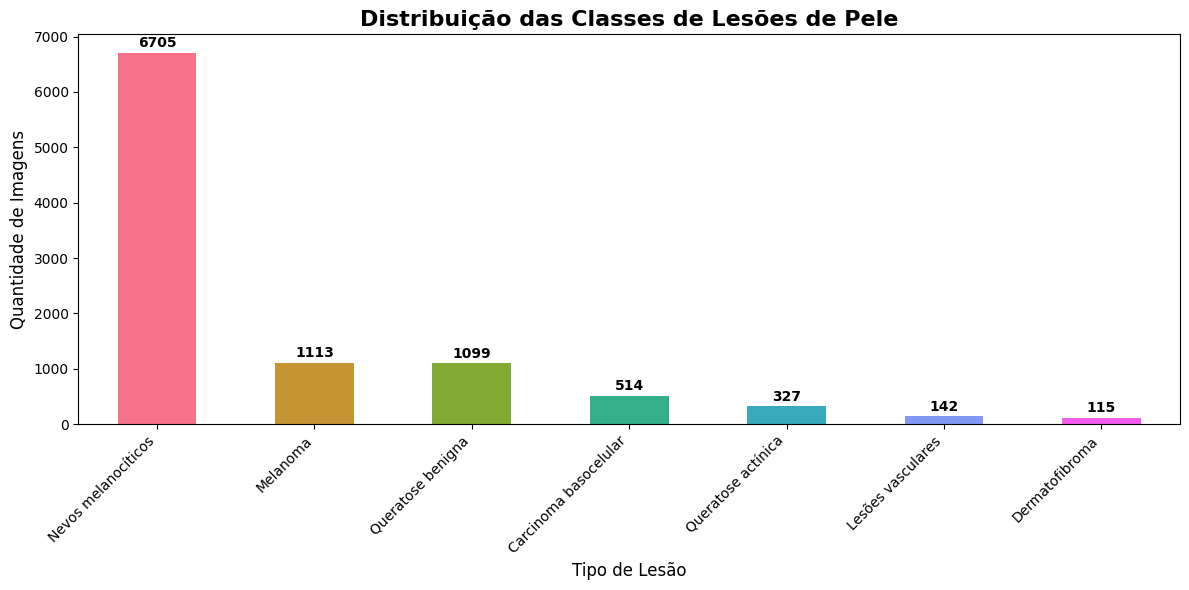


⚠️ OBSERVAÇÃO IMPORTANTE:
O dataset é altamente DESBALANCEADO!
Classe majoritária: Nevos melanocíticos (6705 imagens)
Classe minoritária: Dermatofibroma (115 imagens)
Razão: 58.3x


In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Contar por classe
class_counts = df['class_name'].value_counts()

# Plotar
class_counts.plot(kind='bar', ax=ax, color=sns.color_palette("husl", len(class_counts)))
ax.set_title('Distribuição das Classes de Lesões de Pele', fontsize=16, fontweight='bold')
ax.set_xlabel('Tipo de Lesão', fontsize=12)
ax.set_ylabel('Quantidade de Imagens', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Adicionar valores nas barras
for i, v in enumerate(class_counts.values):
    ax.text(i, v + 100, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n⚠️ OBSERVAÇÃO IMPORTANTE:")
print("O dataset é altamente DESBALANCEADO!")
print(f"Classe majoritária: {class_counts.index[0]} ({class_counts.values[0]} imagens)")
print(f"Classe minoritária: {class_counts.index[-1]} ({class_counts.values[-1]} imagens)")
print(f"Razão: {class_counts.values[0] / class_counts.values[-1]:.1f}x")

O dataset ser desbalanceado implica que algumas classes têm muito mais exemplos do que outras. Isso pode afetar o desempenho do modelo. 

Será necessário considerar técnicas para lidar com esse desbalanceamento, como data augmentation.

### 👥 Outras Distribuições

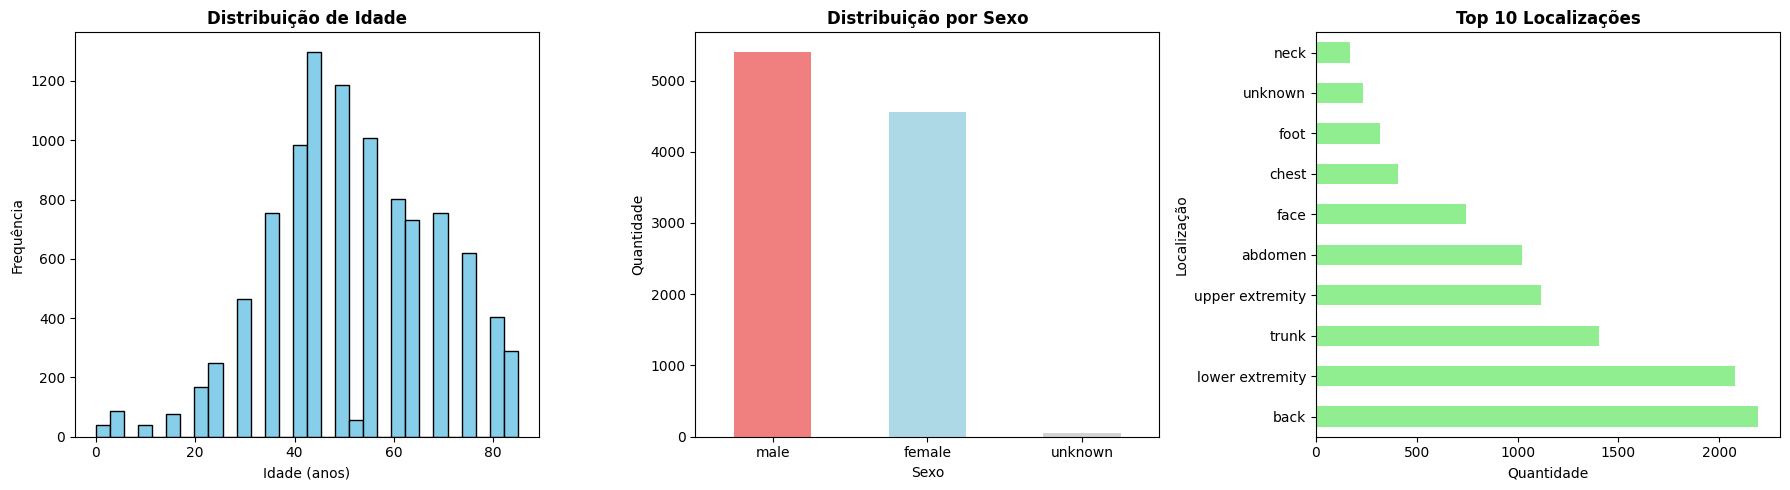

📝 Nota: Embora interessantes, NÃO vamos usar esses dados no modelo.
   Vamos classificar APENAS com base nas imagens!


In [82]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Distribuição de idade
axes[0].hist(df['age'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribuição de Idade', fontweight='bold')
axes[0].set_xlabel('Idade (anos)')
axes[0].set_ylabel('Frequência')

# Distribuição por sexo
df['sex'].value_counts().plot(kind='bar', ax=axes[1], color=['lightcoral', 'lightblue', 'lightgray'])
axes[1].set_title('Distribuição por Sexo', fontweight='bold')
axes[1].set_xlabel('Sexo')
axes[1].set_ylabel('Quantidade')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)

# Distribuição por localização (top 10)
top_locations = df['localization'].value_counts().head(10)
top_locations.plot(kind='barh', ax=axes[2], color='lightgreen')
axes[2].set_title('Top 10 Localizações', fontweight='bold')
axes[2].set_xlabel('Quantidade')
axes[2].set_ylabel('Localização')

plt.tight_layout()
plt.show()

print("📝 Nota: Embora interessantes, NÃO vamos usar esses dados no modelo.")
print("   Vamos classificar APENAS com base nas imagens!")

### 🖼️ Visualização de Amostras de Cada Classe

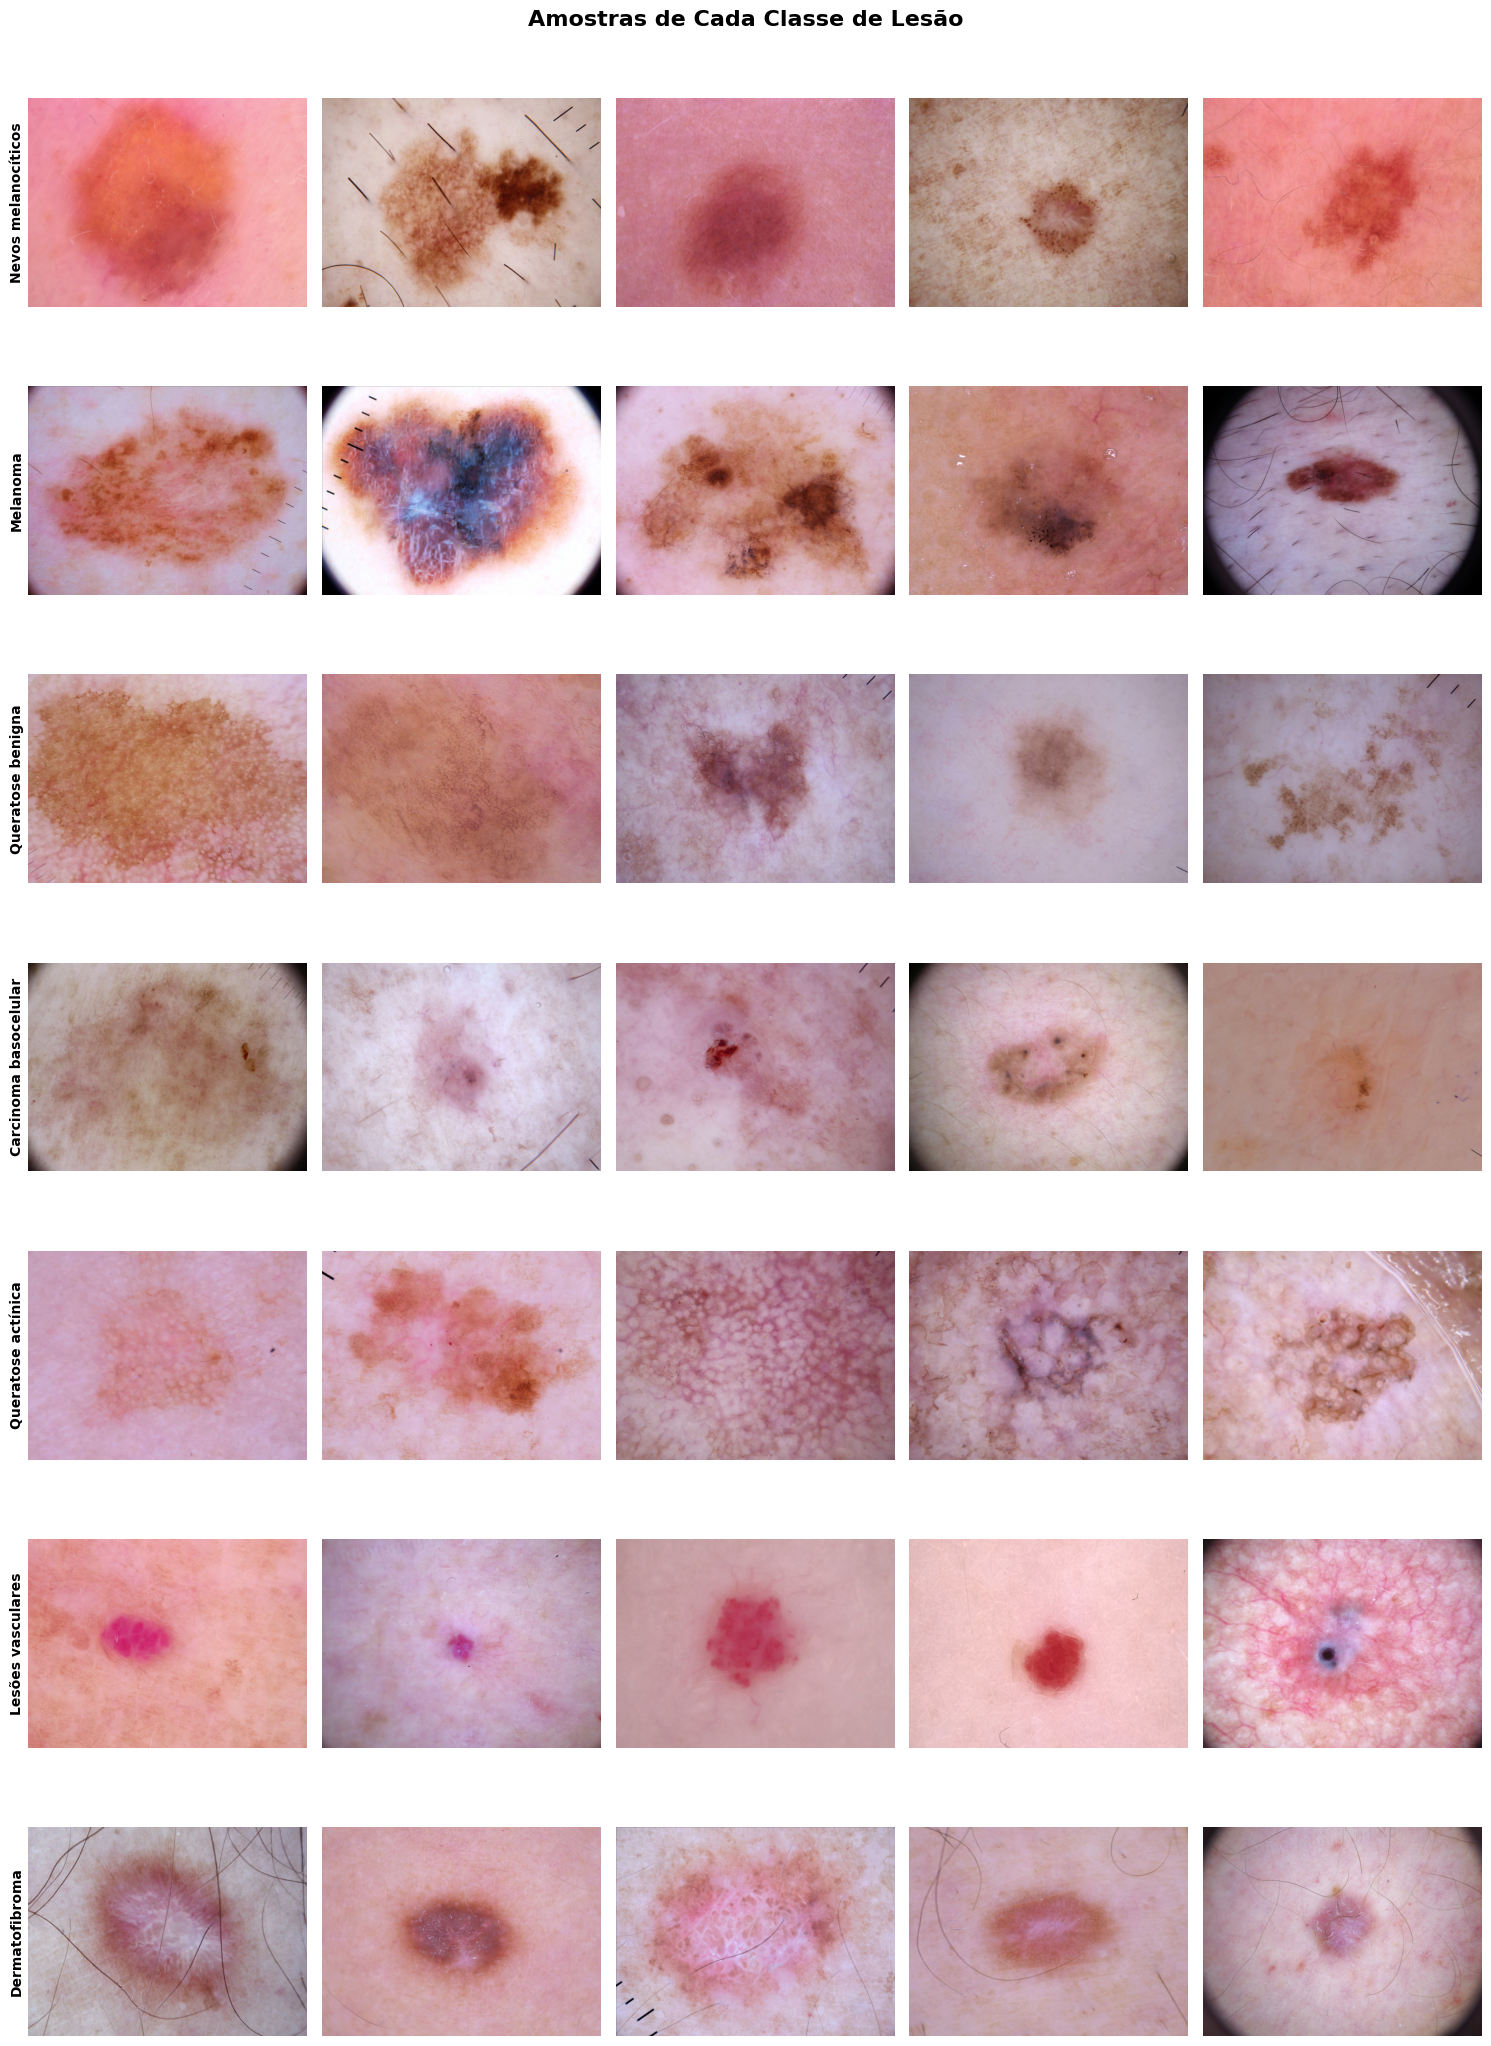

In [83]:
# Plotar 5 exemplos de cada classe
n_samples = 5
fig, axes = plt.subplots(NUM_CLASSES, n_samples, figsize=(n_samples * 3, NUM_CLASSES * 3))

for idx, (class_code, class_label) in enumerate(class_names.items()):
    # Pegar amostras aleatórias da classe
    class_df = df[df['dx'] == class_code]
    n_available = min(n_samples, len(class_df))
    class_samples = class_df.sample(n_available, random_state=SEED)
    
    for col, (_, row) in enumerate(class_samples.iterrows()):
        img = Image.open(row['image_path'])
        axes[idx, col].imshow(img)
        axes[idx, col].axis('off')
        
        # Adicionar título apenas na primeira coluna
        if col == 0:
            axes[idx, col].text(-10, img.size[1]//2, class_label, 
                              fontsize=10, fontweight='bold', 
                              rotation=90, va='center', ha='right')

plt.suptitle('Amostras de Cada Classe de Lesão', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

---
# 4️⃣ Carregamento e Processamento de Imagens

Agora vamos carregar todas as imagens, redimensioná-las e convertê-las em arrays numpy.

In [84]:
print(f"⏳ Carregando e redimensionando {len(df)} imagens para {IMG_WIDTH}x{IMG_HEIGHT}...")
print("   Isso pode levar alguns minutos...")

# Função para carregar e redimensionar imagem
def load_and_resize_image(path):
    try:
        img = Image.open(path)
        img = img.resize((IMG_WIDTH, IMG_HEIGHT))
        return np.array(img)
    except Exception as e:
        print(f"Erro ao carregar {path}: {e}")
        return None

# Carregar imagens
df['image_array'] = df['image_path'].apply(load_and_resize_image)

# Remover imagens que falharam
df = df.dropna(subset=['image_array'])

print(f"✅ {len(df)} imagens carregadas com sucesso!")
print(f"   Shape de cada imagem: {df['image_array'].iloc[0].shape}")

⏳ Carregando e redimensionando 10015 imagens para 100x75...
   Isso pode levar alguns minutos...
✅ 10015 imagens carregadas com sucesso!
   Shape de cada imagem: (75, 100, 3)


In [85]:
# Verificar distribuição de tamanhos
shapes = df['image_array'].apply(lambda x: x.shape).value_counts()
print("\n📐 Distribuição de shapes:")
print(shapes)


📐 Distribuição de shapes:
image_array
(75, 100, 3)    10015
Name: count, dtype: int64


---
# 5️⃣ Divisão dos Dados (Train/Validation/Test)

Vamos dividir em:
- **80%** para treinamento  
- **10%** para validação (do conjunto de treino)  
- **20%** para teste

In [118]:
# Preparar features (X) e labels (y)
X = np.array(df['image_array'].tolist())
y = df['class_idx'].values

print(f"📊 Shape dos dados:")
print(f"   X: {X.shape}")
print(f"   y: {y.shape}")

📊 Shape dos dados:
   X: (10015, 75, 100, 3)
   y: (10015,)


In [119]:
# Primeira divisão: Train (80%) e Test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, 
    test_size=0.20, 
    random_state=SEED,
    stratify=y
)

# Segunda divisão: Train (90% de 80%) e Validation (10% de 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.10,
    random_state=SEED,
    stratify=y_train_full
)

print(f"\n✅ Divisão dos dados:")
print(f"   Treino:     {X_train.shape[0]:5d} imagens ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Validação:  {X_val.shape[0]:5d} imagens ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Teste:      {X_test.shape[0]:5d} imagens ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   TOTAL:      {len(X):5d} imagens")


✅ Divisão dos dados:
   Treino:      7210 imagens (72.0%)
   Validação:    802 imagens (8.0%)
   Teste:       2003 imagens (20.0%)
   TOTAL:      10015 imagens


---
# 6️⃣ Normalização e Encoding

### 🔢 Normalização das Imagens

Vamos normalizar os pixels para terem **média 0 e desvio padrão 1**. Isso ajuda a rede neural a convergir mais rápido.

In [120]:
# Calcular média e desvio padrão do conjunto de treino
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

print(f"📊 Estatísticas do conjunto de treino (antes da normalização):")
print(f"   Média: {X_train_mean:.2f}")
print(f"   Desvio padrão: {X_train_std:.2f}")
print(f"   Min: {X_train.min()}")
print(f"   Max: {X_train.max()}")

# Normalizar todos os conjuntos usando estatísticas do treino
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std

print(f"\n📊 Após normalização:")
print(f"   Média: {X_train.mean():.6f}")
print(f"   Desvio padrão: {X_train.std():.6f}")
print(f"\n✅ Normalização concluída!")

📊 Estatísticas do conjunto de treino (antes da normalização):
   Média: 159.94
   Desvio padrão: 46.47
   Min: 0
   Max: 255

📊 Após normalização:
   Média: 0.000000
   Desvio padrão: 1.000000

✅ Normalização concluída!


### 🏷️ One-Hot Encoding dos Labels

Converter labels numéricos (0-6) em vetores one-hot para classificação multiclasse.

In [121]:
# One-hot encoding
y_train_encoded = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_encoded = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_encoded = to_categorical(y_test, num_classes=NUM_CLASSES)

print(f"🏷️ Exemplo de encoding:")
print(f"   Label original: {y_train[0]}")
print(f"   One-hot encoded: {y_train_encoded[0]}")
print(f"\n✅ Encoding concluído!")

🏷️ Exemplo de encoding:
   Label original: 4
   One-hot encoded: [0. 0. 0. 0. 1. 0. 0.]

✅ Encoding concluído!


### ⚖️ Calcular Class Weights

Como o dataset é muito desbalanceado, vamos calcular **pesos para cada classe**. Classes minoritárias terão peso maior.

In [122]:
# Calcular pesos das classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Converter para dicionário
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("⚖️ Pesos das classes (quanto maior, mais importante):")
for idx, (code, name) in enumerate(class_names.items()):
    count = (y_train == idx).sum()
    weight = class_weight_dict[idx]
    print(f"   Classe {idx} ({code:6s}): peso = {weight:.2f} ({count:4d} imagens)")

print("\n💡 Classes com menos exemplos terão maior peso durante o treinamento!")

⚖️ Pesos das classes (quanto maior, mais importante):
   Classe 0 (nv    ): peso = 4.36 ( 236 imagens)
   Classe 1 (mel   ): peso = 2.78 ( 370 imagens)
   Classe 2 (bkl   ): peso = 1.30 ( 791 imagens)
   Classe 3 (bcc   ): peso = 12.41 (  83 imagens)
   Classe 4 (akiec ): peso = 1.29 ( 801 imagens)
   Classe 5 (vasc  ): peso = 0.21 (4827 imagens)
   Classe 6 (df    ): peso = 10.10 ( 102 imagens)

💡 Classes com menos exemplos terão maior peso durante o treinamento!


---
# 7️⃣ Data Augmentation

### 🔄 Por que Data Augmentation?

**Data Augmentation** cria variações artificiais das imagens de treino aplicando transformações:
- Rotações, Zoom, Deslocamentos
- Mudanças de brilho, Flips

Isso ajuda o modelo a:
1. ✅ Generalizar melhor
2. ✅ Evitar overfitting
3. ✅ Aumentar artificialmente o tamanho do dataset

### 🎨 Configuração Agressiva

Para imagens de pele, vamos usar transformações agressivas porque lesões podem aparecer em qualquer orientação.

In [123]:
# Configurar gerador de data augmentation
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45,           # Rotação aleatória até ±45 graus
    zoom_range=0.2,              # Zoom aleatório até 20%
    width_shift_range=0.15,      # Deslocamento horizontal até 15%
    height_shift_range=0.15,     # Deslocamento vertical até 15%
    horizontal_flip=True,        # Flip horizontal aleatório
    vertical_flip=True,          # Flip vertical aleatório
    # brightness_range=[0.8, 1.2], # Variação de brilho (80% a 120%) -> comentado pq pixel foi normalizado, e 
    # brightness_range trabalha com ranges de 0 a 1 ou 0 a 255
    fill_mode='nearest'
)

# Ajustar ao conjunto de treino
datagen.fit(X_train)

print("✅ Data Augmentation configurado!")
print("\n🔄 Transformações aplicadas:")
print("   • Rotação: ±45°")
print("   • Zoom: até 20%")
print("   • Shifts: até 15%")
print("   • Flips: horizontal e vertical")
print("   • Brilho: 80% a 120%")

✅ Data Augmentation configurado!

🔄 Transformações aplicadas:
   • Rotação: ±45°
   • Zoom: até 20%
   • Shifts: até 15%
   • Flips: horizontal e vertical
   • Brilho: 80% a 120%


### 👀 Visualizar Exemplos de Augmentation

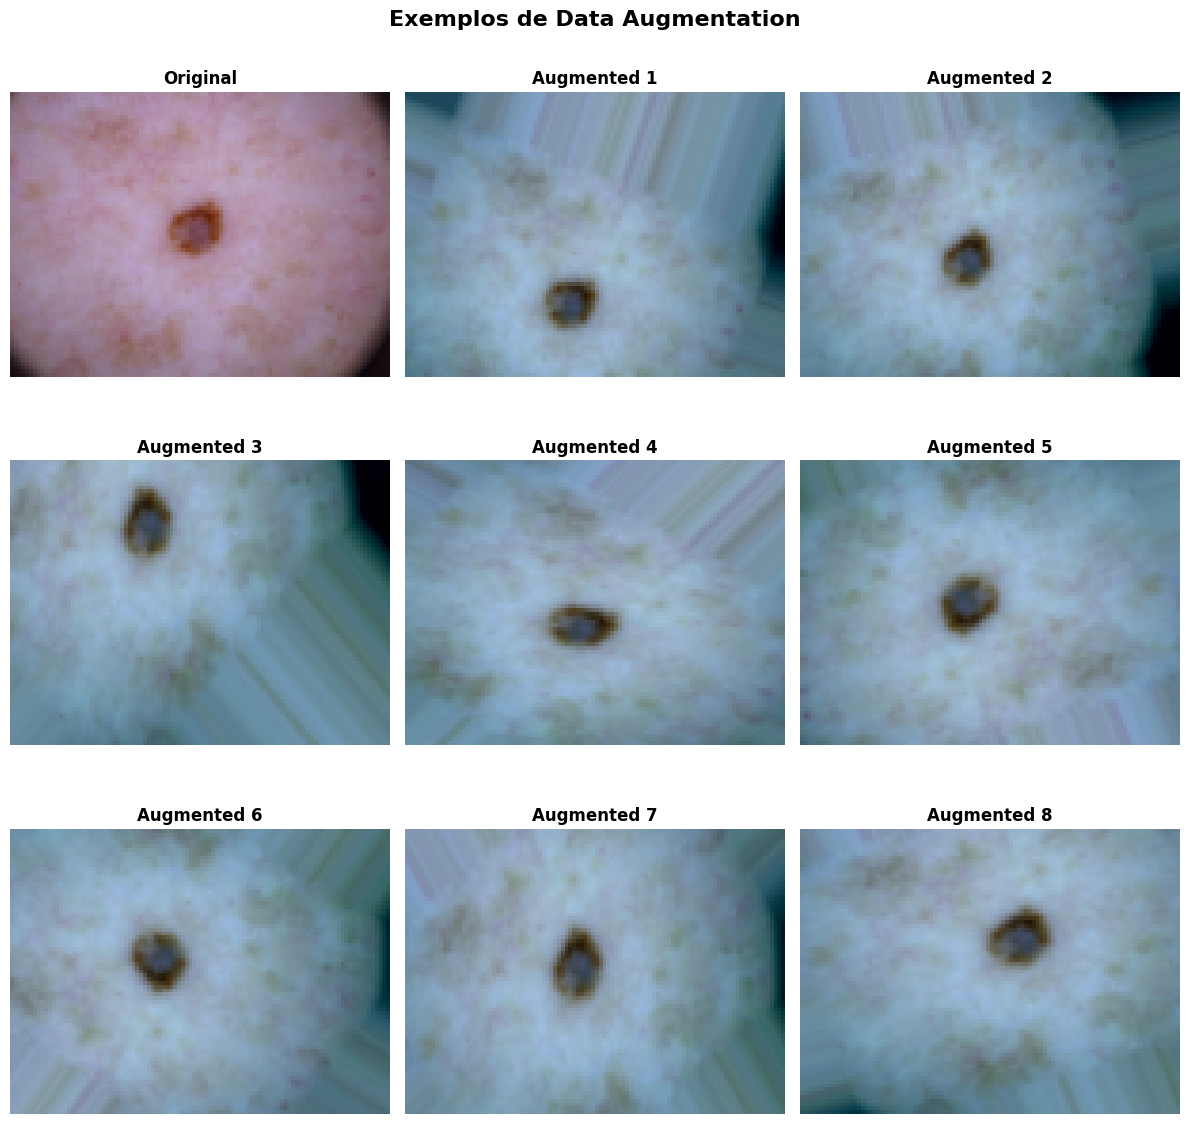


💡 Note como as transformações criam variações realistas!


In [124]:
# Pegar uma imagem de exemplo
sample_img = X_train[0:1]

# Gerar 9 versões augmentadas
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.ravel()

# Desnormalizar para visualização
def denormalize(img):
    img = img * X_train_std + X_train_mean
    return np.clip(img, 0, 255).astype(np.uint8)

for i, ax in enumerate(axes):
    if i == 0:
        ax.imshow(denormalize(sample_img[0]))
        ax.set_title('Original', fontweight='bold')
    else:
        augmented = next(datagen.flow(sample_img, batch_size=1))
        ax.imshow(denormalize(augmented[0]))
        ax.set_title(f'Augmented {i}', fontweight='bold')
    ax.axis('off')

plt.suptitle('Exemplos de Data Augmentation', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n💡 Note como as transformações criam variações realistas!")

---
# 8️⃣ Construção do Modelo CNN

## 🧠 Arquitetura da Rede Neural Convolucional

```
Input (75, 100, 3)
    ↓
[ Conv2D(32) x2 + MaxPool + Dropout(25%) ]
    ↓
[ Conv2D(64) x2 + MaxPool + Dropout(40%) ]
    ↓
[ Flatten + Dense(128) + Dropout(50%) + Dense(7) ]
    ↓
Output (7 classes)
```

### 📚 Explicação dos Componentes:

- **Conv2D**: Aprende filtros para detectar padrões (bordas, texturas)
- **ReLU**: Função de ativação não-linear
- **MaxPooling**: Reduz dimensionalidade
- **Dropout**: Desliga neurônios aleatoriamente para evitar overfitting
- **Softmax**: Converte saída em probabilidades

In [125]:
from tensorflow.keras.layers import SpatialDropout2D, BatchNormalization, Activation

# Construir modelo
model = Sequential([
    # Bloco Convolucional 1
    Conv2D(32, (3, 3), padding='same', use_bias=False,
           input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.3),
    
    # Bloco Convolucional 2
    Conv2D(64, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    SpatialDropout2D(0.40),
    
    # Camadas Densas
    Flatten(),
    Dense(128, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
], name='SkinCancerCNN')

print("\n" + "="*70)
print("📐 ARQUITETURA DO MODELO")
print("="*70)
model.summary()
print("="*70)


📐 ARQUITETURA DO MODELO


Model: "SkinCancerCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 75, 100, 32)    │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 75, 100, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 75, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 75, 100, 32)    │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 75, 100, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 75, 100, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 37, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_6             │ (None, 37, 50, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 37, 50, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 37, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 37, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 37, 50, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 37, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 37, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_7             │ (None, 18, 25, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,686,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,753,959 (14.32 MB)

 Trainable params: 3,753,319 (14.32 MB)

 Non-trainable params: 640 (2.50 KB)

---
# 9️⃣ Compilação do Modelo

## 🎯 Otimizador Adam

**Adam (Adaptive Moment Estimation)** é um dos melhores otimizadores porque:

1. ✅ **Adapta a taxa de aprendizado** para cada parâmetro
2. ✅ **Combina AdaGrad + RMSprop**
3. ✅ **Converge rapidamente**
4. ✅ **Robusto a hiperparâmetros**

### 📉 Learning Rate Scheduling (ReduceLROnPlateau)

Se a validação parar de melhorar por 3 epochs → reduz LR em 50%

In [126]:
# Configurar otimizador
optimizer = Adam(learning_rate=LEARNING_RATE)

# Compilar modelo
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Modelo compilado!")
print(f"\n⚙️ Configurações:")
print(f"   Otimizador: Adam")
print(f"   Learning Rate inicial: {LEARNING_RATE}")
print(f"   Loss: categorical_crossentropy")

✅ Modelo compilado!

⚙️ Configurações:
   Otimizador: Adam
   Learning Rate inicial: 0.01
   Loss: categorical_crossentropy


### 🔔 Configurar Callbacks

In [127]:
# Callback 1: Reduzir learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

# Callback 2: Salvar melhor modelo
checkpoint_path = os.path.join(MODELS_DIR, 'best_cnn_model.h5')
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback 3: Early stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

callbacks = [reduce_lr, model_checkpoint, early_stop]

print("✅ Callbacks configurados:")
print("   1. ReduceLROnPlateau")
print("   2. ModelCheckpoint")
print("   3. EarlyStopping")

✅ Callbacks configurados:
   1. ReduceLROnPlateau
   2. ModelCheckpoint
   3. EarlyStopping


---
# 🔟 Treinamento do Modelo

Agora vamos treinar! Isso pode levar **30 min a 1 hora**.

**Métricas:**
- **loss**: erro no treino (↓ melhor)
- **accuracy**: acurácia no treino (↑ melhor)
- **val_loss**: erro na validação
- **val_accuracy**: acurácia na validação

**Objetivo:** val_accuracy alto e próximo de accuracy

In [ ]:
print("\n" + "="*70)
print("🚀 INICIANDO TREINAMENTO")
print("="*70)
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps por epoch: {len(X_train) // BATCH_SIZE}")
print("="*70 + "\n")

# Treinar modelo
history = model.fit(
    datagen.flow(X_train, y_train_encoded, batch_size=BATCH_SIZE),
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_encoded),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

print("\n" + "="*70)
print("✅ TREINAMENTO CONCLUÍDO!")
print("="*70)


🚀 INICIANDO TREINAMENTO
Epochs: 50
Batch size: 10
Steps por epoch: 721

Epoch 1/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2605 - loss: 2.3247
Epoch 1: val_accuracy improved from None to 0.53865, saving model to ..\models\best_cnn_model.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 111s 145ms/step - accuracy: 0.2494 - loss: 2.1570 - val_accuracy: 0.5387 - val_loss: 1.2120 - learning_rate: 0.0100
Epoch 2/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2548 - loss: 1.8239
Epoch 2: val_accuracy did not improve from 0.53865
721/721 ━━━━━━━━━━━━━━━━━━━━ 97s 135ms/step - accuracy: 0.2759 - loss: 1.8513 - val_accuracy: 0.5150 - val_loss: 1.2995 - learning_rate: 0.0100
Epoch 3/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2943 - loss: 1.8619
Epoch 3: val_accuracy did not improve from 0.53865
721/721 ━━━━━━━━━━━━━━━━━━━━ 91s 127ms/step - accuracy: 0.2716 - loss: 1.8516 - val_accuracy: 0.4938 - val_loss: 1.4911 - learning_rate: 0.0100
Epoch 4/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2863 - loss: 1.8520
Epoch 4: val_accuracy improved from 0.53865 to 0.57606, saving model to ..\models\best_cnn_model.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 101s 140ms/step - accuracy: 0.2822 - loss: 1.8297 - val_accuracy: 0.5761 - val_loss: 1.1951 - learning_rate: 0.0100
Epoch 5/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 691ms/step - accuracy: 0.3297 - loss: 1.7923
Epoch 5: val_accuracy did not improve from 0.57606
721/721 ━━━━━━━━━━━━━━━━━━━━ 500s 694ms/step - accuracy: 0.3261 - loss: 1.7995 - val_accuracy: 0.4938 - val_loss: 1.2948 - learning_rate: 0.0100
Epoch 6/50
721/721 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3042 - loss: 1.8528
Epoch 6: val_accuracy improved from 0.57606 to 0.64339, saving model to ..\models\best_cnn_model.h5


721/721 ━━━━━━━━━━━━━━━━━━━━ 100s 138ms/step - accuracy: 0.3128 - loss: 1.8047 - val_accuracy: 0.6434 - val_loss: 1.0991 - learning_rate: 0.0100
Epoch 7/50
403/721 ━━━━━━━━━━━━━━━━━━━━ 42s 135ms/step - accuracy: 0.3286 - loss: 1.8890

---
# 1️⃣1️⃣ Visualização do Treinamento

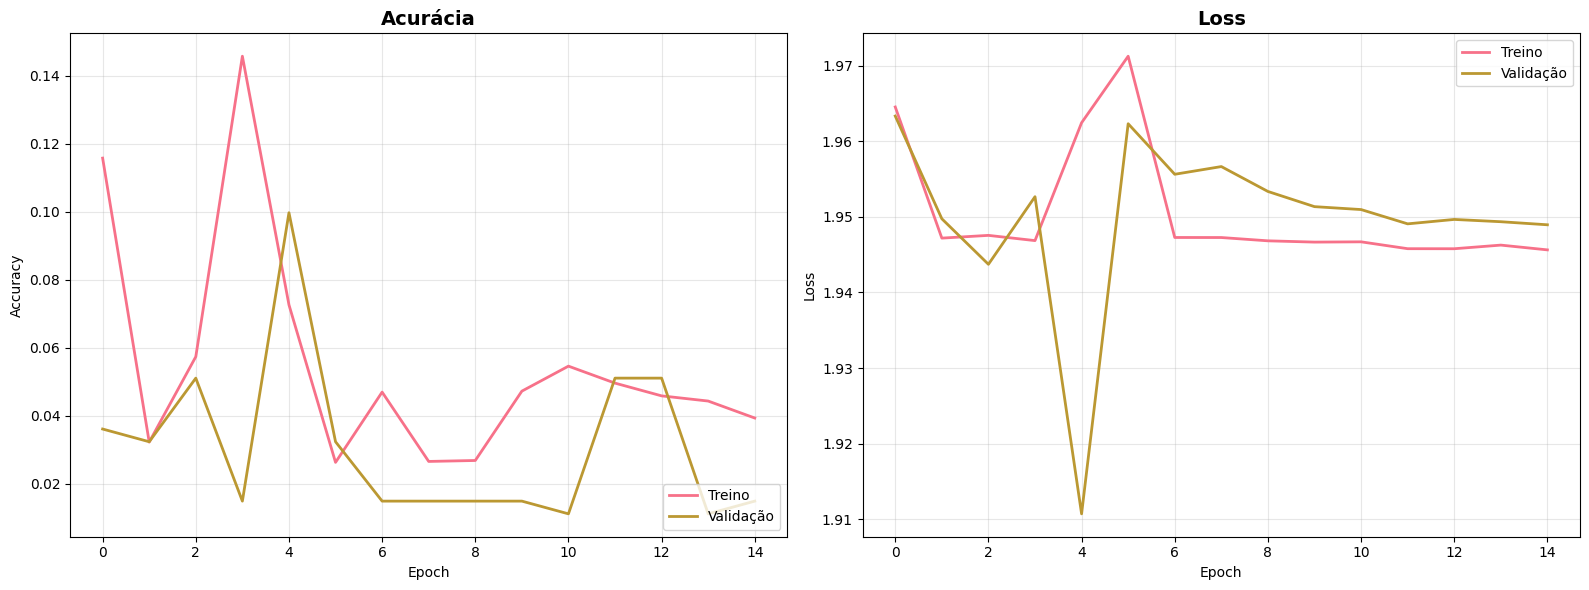

In [ ]:
# Plotar histórico
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Treino', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validação', linewidth=2)
axes[0].set_title('Acurácia', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Treino', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validação', linewidth=2)
axes[1].set_title('Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Análise do treinamento
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
best_val_acc = max(history.history['val_accuracy'])

print("📊 RESUMO DO TREINAMENTO")
print("="*50)
print(f"Acurácia final no treino:     {final_train_acc*100:.2f}%")
print(f"Acurácia final na validação:  {final_val_acc*100:.2f}%")
print(f"Melhor acurácia na validação: {best_val_acc*100:.2f}%")
print(f"Diferença treino-validação:   {(final_train_acc - final_val_acc)*100:.2f}%")
print("="*50)

if (final_train_acc - final_val_acc) < 0.05:
    print("\n✅ Boa generalização!")
elif (final_train_acc - final_val_acc) < 0.10:
    print("\n⚠️ Leve overfitting.")
else:
    print("\n❌ Overfitting significativo!")

📊 RESUMO DO TREINAMENTO
Acurácia final no treino:     3.94%
Acurácia final na validação:  1.50%
Melhor acurácia na validação: 9.98%
Diferença treino-validação:   2.44%

✅ Boa generalização!


---
# 1️⃣2️⃣ Avaliação no Conjunto de Teste

In [ ]:
# Avaliar no teste
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)

print("\n" + "="*70)
print("🎯 RESULTADOS NO CONJUNTO DE TESTE")
print("="*70)
print(f"Test Loss:     {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print("="*70)

print(f"\n📊 Comparação:")
print(f"   Validação: {final_val_acc*100:.2f}%")
print(f"   Teste:     {test_accuracy*100:.2f}%")

if abs(final_val_acc - test_accuracy) < 0.03:
    print("\n✅ Resultados consistentes!")
else:
    print("\n⚠️ Há diferença entre validação e teste.")


🎯 RESULTADOS NO CONJUNTO DE TESTE
Test Loss:     1.9045
Test Accuracy: 9.39%

📊 Comparação:
   Validação: 1.50%
   Teste:     9.39%

⚠️ Há diferença entre validação e teste.


---
# 1️⃣3️⃣ Análise Detalhada: Matriz de Confusão

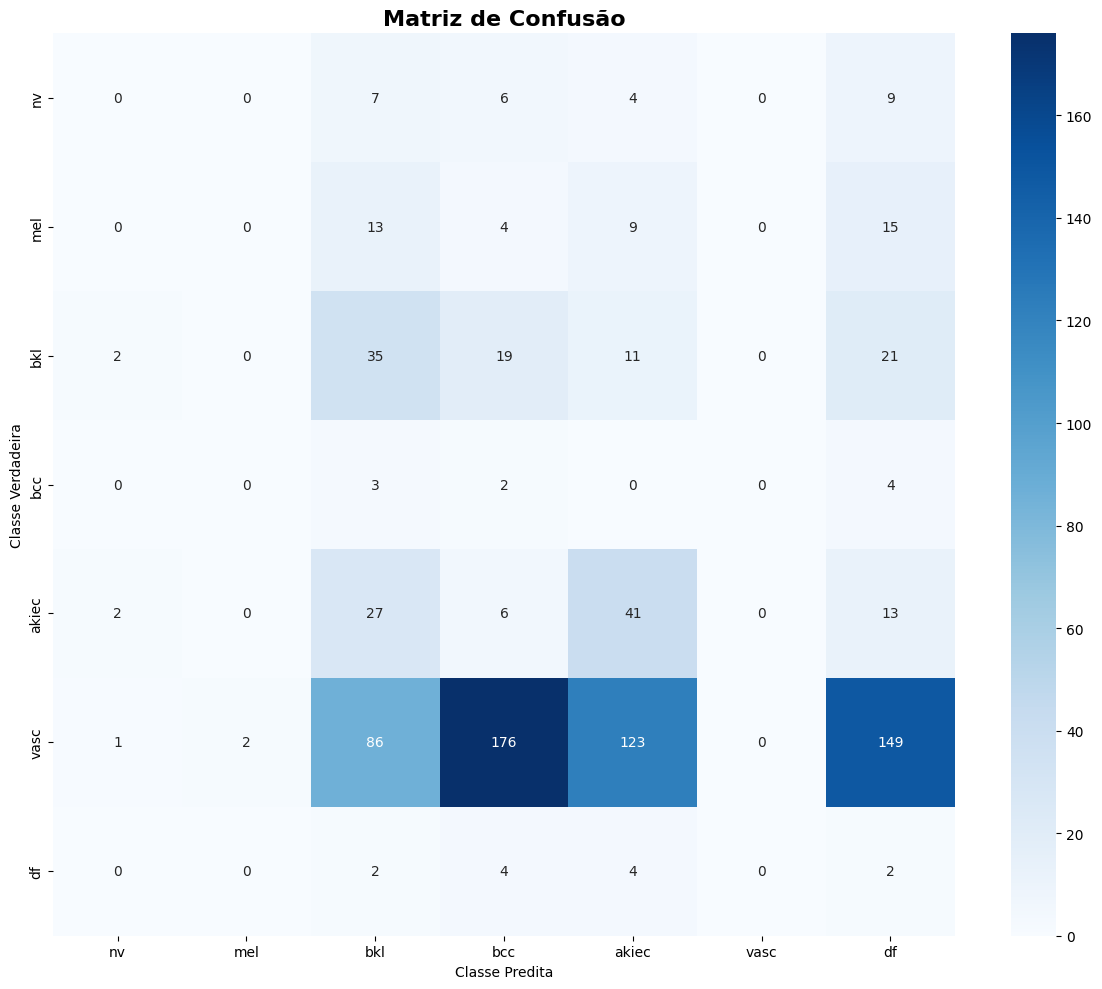


💡 Diagonal principal = acertos
   Fora da diagonal = confusões


In [ ]:
# Fazer predições no conjunto de validação
y_pred_probs = model.predict(X_val, verbose=0)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = y_val

# Calcular matriz de confusão
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotar
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(class_names.keys()),
            yticklabels=list(class_names.keys()))
plt.title('Matriz de Confusão', fontsize=16, fontweight='bold')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.tight_layout()
plt.show()

print("\n💡 Diagonal principal = acertos")
print("   Fora da diagonal = confusões")

---
# 1️⃣4️⃣ Métricas Por Classe

In [ ]:
# Relatório de classificação
print("\n" + "="*80)
print("📊 RELATÓRIO DE CLASSIFICAÇÃO")
print("="*80)
report = classification_report(
    y_true_classes, 
    y_pred_classes, 
    target_names=list(class_names.values()),
    digits=4
)
print(report)
print("="*80)

print("\n📚 Glossário:")
print("   • Precision: Acertos / Total predito como classe X")
print("   • Recall: Acertos / Total real da classe X")
print("   • F1-Score: Média harmônica de Precision e Recall")


📊 RELATÓRIO DE CLASSIFICAÇÃO
                       precision    recall  f1-score   support

  Nevos melanocíticos     0.0000    0.0000    0.0000        26
             Melanoma     0.0000    0.0000    0.0000        41
    Queratose benigna     0.2023    0.3977    0.2682        88
Carcinoma basocelular     0.0092    0.2222    0.0177         9
   Queratose actínica     0.2135    0.4607    0.2918        89
    Lesões vasculares     0.0000    0.0000    0.0000       537
       Dermatofibroma     0.0094    0.1667    0.0178        12

             accuracy                         0.0998       802
            macro avg     0.0621    0.1782    0.0851       802
         weighted avg     0.0461    0.0998    0.0623       802


📚 Glossário:
   • Precision: Acertos / Total predito como classe X
   • Recall: Acertos / Total real da classe X
   • F1-Score: Média harmônica de Precision e Recall


### 📊 Taxa de Erro Por Classe

In [ ]:
# Calcular taxa de erro por classe
class_correct = np.diag(cm)
class_total = np.sum(cm, axis=1)
class_accuracy = class_correct / class_total
class_error = 1 - class_accuracy

# Plotar
fig, ax = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(class_names))

bars = ax.bar(x_pos, class_error, edgecolor='black')
ax.set_xlabel('Classe')
ax.set_ylabel('Taxa de Erro')
ax.set_title('Taxa de Erro por Classe', fontsize=16, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(list(class_names.keys()))
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3)

# Valores nas barras
for bar, error in zip(bars, class_error):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{error*100:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Análise
worst_idx = np.argmax(class_error)
best_idx = np.argmin(class_error)
worst_class = list(class_names.keys())[worst_idx]
best_class = list(class_names.keys())[best_idx]

print(f"\n📈 Classe com MAIOR erro: {worst_class} ({class_error[worst_idx]*100:.2f}%)")
print(f"📉 Classe com MENOR erro: {best_class} ({class_error[best_idx]*100:.2f}%)")

---
# 1️⃣5️⃣ Salvar Modelo Final

In [ ]:
# Salvar modelo final
final_model_path = os.path.join(MODELS_DIR, 'cnn_skin_cancer_final.h5')
model.save(final_model_path)

print("💾 Modelos salvos:")
print(f"   1. Melhor: {checkpoint_path}")
print(f"   2. Final:  {final_model_path}")
print("\n✅ Carregar depois com:")
print("   model = keras.models.load_model('caminho.h5')")

---
# 1️⃣6️⃣ Conclusões e Próximos Passos

## 📝 Resumo

Implementamos uma **CNN do zero** para classificar lesões de pele usando apenas imagens.

### ✅ O que fizemos:

1. Carregamos e exploramos HAM10000 (10k+ imagens, 7 classes)
2. Processamos imagens (resize, normalização)
3. Lidamos com desbalanceamento (class weights)
4. Aplicamos Data Augmentation agressivo
5. Construímos CNN com regularização
6. Treinamos com Adam + learning rate scheduling
7. Avaliamos com métricas detalhadas

### 🎯 Resultados:

In [ ]:
print("\n" + "="*70)
print("🏆 RESULTADOS FINAIS")
print("="*70)
print(f"Acurácia no Treino:      {final_train_acc*100:.2f}%")
print(f"Acurácia na Validação:   {final_val_acc*100:.2f}%")
print(f"Acurácia no Teste:       {test_accuracy*100:.2f}%")
print(f"\nMelhor Val Accuracy:     {best_val_acc*100:.2f}%")
print("="*70)

### 🔍 Observações:

1. **Dataset Desbalanceado**: Usamos class weights
2. **Data Augmentation é Crucial**: Evita overfitting
3. **Regularização**: Dropout + LR scheduling ajudam
4. **Limitações**: Imagens pequenas (100x75) perdem detalhes

### 🚀 Próximos Passos:

1. **Vision Transformer (ViT)**: Implementar e comparar
2. **Comparação com VLMs**: Testar Gemini, GPT-4V, Claude
3. **Melhorias**:
   - Transfer Learning (ResNet50, EfficientNet)
   - Imagens maiores (224x224)
   - Ensemble de modelos

### 💡 Lições:

- ✅ CNNs funcionam bem para imagens médicas
- ✅ Data Augmentation e regularização são essenciais
- ✅ Desbalanceamento requer atenção especial
- ✅ Análise detalhada revela insights importantes

---

## 🎓 Fim do Notebook

**Modelo baseline criado!** Pronto para comparar com arquiteturas avançadas.
